In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download()
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from scipy.sparse import hstack
from argparse import Namespace
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [116]:
# Read raw data
df = pd.read_csv('data/oreilly.csv', header=0)

In [117]:
df.head()

,title,level,overview,url
0,AI Engineering,Intermediate to advanced,Recent breakthroughs in AI have not only incre...,https://learning.oreilly.com/library/view/-/97...
1,"Designing Data-Intensive Applications, 2nd Edi...",Intermediate to advanced,"In this second edition, authors Martin Kleppma...",https://learning.oreilly.com/library/view/-/97...
2,Building Applications with AI Agents,Beginner to intermediate,Generative AI has revolutionized how organizat...,https://learning.oreilly.com/library/view/-/97...
3,Hands-On Machine Learning with Scikit-Learn an...,Intermediate to advanced,The potential of machine learning today is ext...,https://learning.oreilly.com/library/view/-/97...
4,"Hands-On Machine Learning with Scikit-Learn, K...",Intermediate to advanced,"Through a recent series of breakthroughs, deep...",https://learning.oreilly.com/library/view/-/97...


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     2456 non-null   object
 1   level     2456 non-null   object
 2   overview  2328 non-null   object
 3   url       2456 non-null   object
dtypes: object(4)
memory usage: 76.9+ KB


In [119]:
# remove all the rows with null
df = df[df.overview.isna() == False]
df = df[df.level.isna() == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2328 entries, 0 to 2454
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     2328 non-null   object
 1   level     2328 non-null   object
 2   overview  2328 non-null   object
 3   url       2328 non-null   object
dtypes: object(4)
memory usage: 90.9+ KB


In [120]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\b(\w+)\s+edition\b", '', text)
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s.?!,-]', '', text)

    text = re.sub(r"([.,!?])", r" \1 ", text)  # E.g., convert "end." to "end . " ; \1 indicates a matched character
    
    return text.strip()
    
df.title = df.title.apply(clean_text)
df.overview = df.overview.apply(clean_text)
df.head()

,title,level,overview,url
0,ai engineering,Intermediate to advanced,recent breakthroughs in ai have not only incre...,https://learning.oreilly.com/library/view/-/97...
1,"designing data-intensive applications ,",Intermediate to advanced,"in this , authors martin kleppmann and chris...",https://learning.oreilly.com/library/view/-/97...
2,building applications with ai agents,Beginner to intermediate,generative ai has revolutionized how organizat...,https://learning.oreilly.com/library/view/-/97...
3,hands-on machine learning with scikit-learn an...,Intermediate to advanced,the potential of machine learning today is ext...,https://learning.oreilly.com/library/view/-/97...
4,"hands-on machine learning with scikit-learn , ...",Intermediate to advanced,"through a recent series of breakthroughs , de...",https://learning.oreilly.com/library/view/-/97...


In [121]:
NLTK_STOP_WORDS = set(stopwords.words('english'))
CUSTOM_STOPS = {'.', ',', ';', ':', '?', '!', ' ', "n't", 'und', 'die', 'book', 'study'}
ALL_STOP_WORDS = NLTK_STOP_WORDS.union(CUSTOM_STOPS)


def filter_stopwords(text):
    words = word_tokenize(text)
    return [word for word in words if word not in ALL_STOP_WORDS]

# Apply stopword filtering to review titles and content
df['title'] = df.title.apply(filter_stopwords)
df['overview'] = df.overview.apply(filter_stopwords)
df.head()

,title,level,overview,url
0,"[ai, engineering]",Intermediate to advanced,"[recent, breakthroughs, ai, increased, demand,...",https://learning.oreilly.com/library/view/-/97...
1,"[designing, data-intensive, applications]",Intermediate to advanced,"[authors, martin, kleppmann, chris, riccomini,...",https://learning.oreilly.com/library/view/-/97...
2,"[building, applications, ai, agents]",Beginner to intermediate,"[generative, ai, revolutionized, organizations...",https://learning.oreilly.com/library/view/-/97...
3,"[hands-on, machine, learning, scikit-learn, py...",Intermediate to advanced,"[potential, machine, learning, today, extraord...",https://learning.oreilly.com/library/view/-/97...
4,"[hands-on, machine, learning, scikit-learn, ke...",Intermediate to advanced,"[recent, series, breakthroughs, deep, learning...",https://learning.oreilly.com/library/view/-/97...


In [122]:
def get_wordnet_pos(tag):
    if tag.startswith('J'): # Adjective 
        return wordnet.ADJ
    elif tag.startswith('V'): # Verb 
        return wordnet.VERB
    elif tag.startswith('N'): # Noun
        return wordnet.NOUN
    elif tag.startswith('R'): # Adverb 
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_words_with_pos(word_list):

    lemmatizer = WordNetLemmatizer()
    
    tagged_words = nltk.pos_tag(word_list)
    
    lemmatized_list = []
    
    for word, tag in tagged_words:
        wntag = get_wordnet_pos(tag)
    
        lemmatized_word = lemmatizer.lemmatize(word, pos=wntag)
        lemmatized_list.append(lemmatized_word)
        
    return lemmatized_list

df['title'] = df.title.apply(lemmatize_words_with_pos)
df['overview'] = df.overview.apply(lemmatize_words_with_pos)
df.head()

,title,level,overview,url
0,"[ai, engineering]",Intermediate to advanced,"[recent, breakthrough, ai, increase, demand, a...",https://learning.oreilly.com/library/view/-/97...
1,"[design, data-intensive, application]",Intermediate to advanced,"[author, martin, kleppmann, chris, riccomini, ...",https://learning.oreilly.com/library/view/-/97...
2,"[building, application, ai, agent]",Beginner to intermediate,"[generative, ai, revolutionize, organization, ...",https://learning.oreilly.com/library/view/-/97...
3,"[hands-on, machine, learn, scikit-learn, pytorch]",Intermediate to advanced,"[potential, machine, learn, today, extraordina...",https://learning.oreilly.com/library/view/-/97...
4,"[hands-on, machine, learn, scikit-learn, kera,...",Intermediate to advanced,"[recent, series, breakthroughs, deep, learning...",https://learning.oreilly.com/library/view/-/97...


In [123]:
df['text'] = df['title'] + df['overview']
df['word_length'] = df['text'].apply(lambda x: len(x))
df = df[df['word_length'] > 10]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2307 entries, 0 to 2454
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        2307 non-null   object
 1   level        2307 non-null   object
 2   overview     2307 non-null   object
 3   url          2307 non-null   object
 4   text         2307 non-null   object
 5   word_length  2307 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 126.2+ KB


In [124]:
df_processed = df[['title', 'level', 'text']].copy()
df_processed['title'] = df_processed['title'].apply(lambda x: ' '.join(x))

## Clustering

In [125]:
totalvocab = []
for i in df_processed['text']:
    totalvocab.extend(i) 

In [126]:
vocab_frame = pd.DataFrame({'words': totalvocab}, index = totalvocab)
vocab_frame.head()

,words
ai,ai
engineering,engineering
recent,recent
breakthrough,breakthrough
ai,ai


In [127]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))

# %time is built-in magic command; https://ipython.org/ipython-doc/3/interactive/magics.html 
%time tfidf_matrix = tfidf_vectorizer.fit_transform(df_processed['text'].apply(lambda x: ' '.join(x)))

print(tfidf_matrix.shape)

CPU times: user 799 ms, sys: 18.9 ms, total: 818 ms
Wall time: 817 ms
(2307, 311)


In [128]:
terms = tfidf_vectorizer.get_feature_names_out()
dist = 1 - cosine_similarity(tfidf_matrix) # euclidean_distances() can be used also.

In [129]:
np.random.seed(1234)
num_clusters = 4
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 8.53 ms, sys: 1.55 ms, total: 10.1 ms
Wall time: 5.58 ms


In [130]:
df_processed['cluster'] = clusters
df_processed['cluster'].value_counts()

cluster
3    921
1    575
2    511
0    300
Name: count, dtype: int64

In [131]:
cluster_centers = km.cluster_centers_
order_centroids = cluster_centers.argsort()[:, ::-1] 
important_words = {
    0 : [],
    1 : [],
    2 : [],
    3 : []
}
title_list = {
    0 : [],
    1 : [],
    2 : [],
    3 : []
}


print("\n\n#################################################################")
print("               Top/Exclusive Terms                        ")
print("#################################################################")

for i in range(num_clusters):
    print(f"\n======== cluster{i} ========")
    
    print("Top Terms:", end='')
    for ind in order_centroids[i, :100]: 
        print(f' {terms[ind]}', end=' |')
        important_words[i].append(terms[ind])

    print()
    
    print(f"\ncluster {i} title ({len(df_processed[df_processed['cluster'] == i])}):")
    
    current_cluster_titles = df_processed[df_processed['cluster'] == i]['title'].values.tolist()
    
    for title in current_cluster_titles:
        print(f' - {title}')
        title_list[i].append(title)
    print()




#################################################################
               Top/Exclusive Terms                        
#################################################################

======== cluster0 ========
Top Terms: data | ai | learn | use | machine | model | science | python | application | analysis | build | practical | tool | technique | real | youll | business | learning | design | guide | include | understand | world | create | language | like | engineer | real world | solution | implement | concept | database | knowledge | structure | deep | make | author | provide | method | help | engineering | apply | insight | cloud | technology | problem | work | code | complex | explore | program | power | software | architecture | advance | professional | master | example | new | need | case | experience | process | industry | feature | large | scale | skill | practice | youll learn | advanced | basic | analyze | hands | performance | developer | develop | challenge | infor

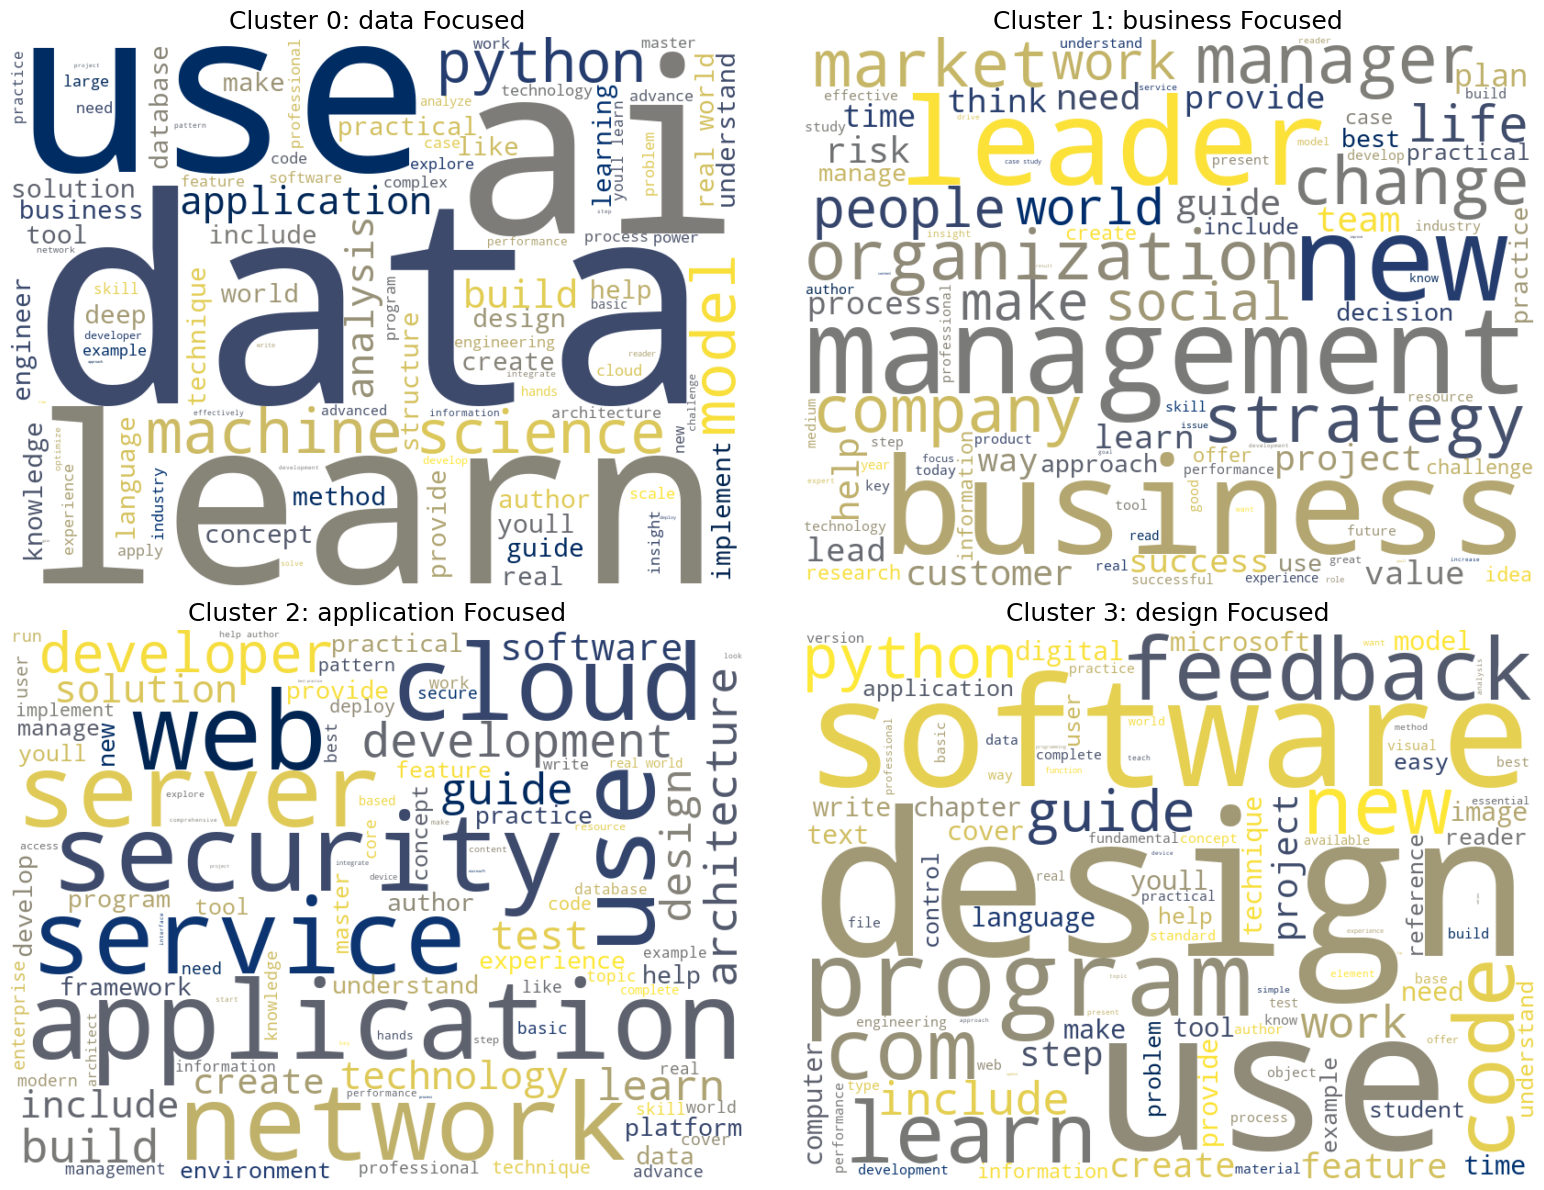

In [132]:
def generate_wordcloud_from_rank(important_words_lists):
    
    num_clusters = len(important_words_lists)
    cols = 2  #
    rows = int(np.ceil(num_clusters / cols))
    
    plt.figure(figsize=(cols * 8, rows * 6))

    for k, word_list in important_words_lists.items():

        max_rank_weight = len(word_list)
        frequency_dict = {
            word: max_rank_weight - rank 
            for rank, word in enumerate(word_list)
        }
        
        frequency_dict = {w: f for w, f in frequency_dict.items() if f > 0}

        if not frequency_dict:
            continue

        wordcloud = WordCloud(
            width=800, 
            height=600, 
            background_color='white',
            colormap='cividis', 
            max_words=100,
            relative_scaling=1.0 
        )

        wordcloud.generate_from_frequencies(frequency_dict)
        
        plt.subplot(rows, cols, k + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Cluster {k}: {list(word_list)[0]} Focused', fontsize=18)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

generate_wordcloud_from_rank(important_words)

Cluster 0: 300 documents
Cluster 1: 575 documents
Cluster 2: 511 documents
Cluster 3: 921 documents


/var/folders/8t/d2wnktds38596jzn7mbqcn280000gn/T/ipykernel_10894/977262800.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Spectral', len(unique_labels))


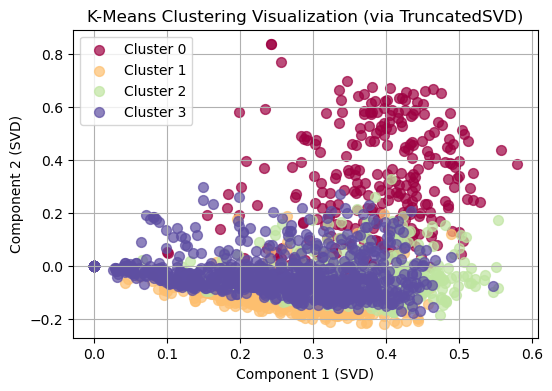

In [133]:
unique_labels, counts = np.unique(clusters, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} documents")


# --- Core visualization steps ---

# 1. Reduce to 2D using TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
reduced_data = svd.fit_transform(tfidf_matrix)


# 2. Create a color map, one color per cluster
unique_labels = np.unique(clusters)
colors = plt.cm.get_cmap('Spectral', len(unique_labels))

# 3. Draw scatter plot
plt.figure(figsize=(6, 4))
for i, label in enumerate(unique_labels):
    # Find all points for the current cluster
    indices = clusters == label
    plt.scatter(
        reduced_data[indices, 0], 
        reduced_data[indices, 1], 
        label=f'Cluster {label}',
        color=colors(i),
        alpha=0.7,
        s=50
    )

plt.title('K-Means Clustering Visualization (via TruncatedSVD)')
plt.xlabel('Component 1 (SVD)')
plt.ylabel('Component 2 (SVD)')
plt.legend()
plt.grid(True)
plt.show()

## Classification

In [134]:
df_cl = df_processed[['text','level']]
df_cl['text'] = df_cl['text'].apply(lambda x: ' '.join(x))
df_cl.head()

/var/folders/8t/d2wnktds38596jzn7mbqcn280000gn/T/ipykernel_10894/1453794326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['text'] = df_cl['text'].apply(lambda x: ' '.join(x))


,text,level
0,ai engineering recent breakthrough ai increase...,Intermediate to advanced
1,design data-intensive application author marti...,Intermediate to advanced
2,building application ai agent generative ai re...,Beginner to intermediate
3,hands-on machine learn scikit-learn pytorch po...,Intermediate to advanced
4,hands-on machine learn scikit-learn kera tenso...,Intermediate to advanced


In [135]:
df_cl['level'].value_counts()

level
Intermediate to advanced    1505
Beginner                     463
Beginner to intermediate     334
Intermediate                   4
512 pages                      1
Name: count, dtype: int64

In [136]:
df_cl = df_cl[df_cl['level'] != '512 pages']

In [137]:
df_cl['label'] = df_cl['level'].apply(lambda x : 'basic' if x in ['Beginner to intermediate', 'Beginner'] else 'advanced')
df_cl['label'].value_counts()

label
advanced    1509
basic        797
Name: count, dtype: int64

In [138]:
# Use a LabelEncoder to convert the categorical status column into numerical labels
lbl_enc = LabelEncoder()
df_cl['label'] = lbl_enc.fit_transform(df_cl['label'].values)


# Create a dictionary to store the mapping between the new numerical codes and the original text labels.
original_labels = lbl_enc.classes_
encoded_labels = np.arange(len(original_labels))

zipped_pairs = zip(encoded_labels, original_labels)
label_map = dict(zipped_pairs)

label_map

{np.int64(0): 'advanced', np.int64(1): 'basic'}

In [139]:
df_X = df_cl[['text']]
df_y = df_cl[['label']]

In [140]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, 
                                                    test_size = 0.3,
                                                    random_state=123)

In [141]:
tfidf_vect = TfidfVectorizer(
        max_features=10000,
        stop_words='english',
        ngram_range=(1, 2)
    )

xtrain_tfidf =  tfidf_vect.fit_transform(X_train['text'])
xtest_tfidf =  tfidf_vect.transform(X_test['text'])
y_train = y_train['label']
y_test = y_test['label']

In [142]:
y_train.value_counts()

label
0    1080
1     534
Name: count, dtype: int64

In [143]:
# Apply SMOTE (Synthetic Minority Oversampling Technique) to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(xtrain_tfidf, y_train)
y_train_resampled.value_counts()

label
0    1080
1    1080
Name: count, dtype: int64

In [144]:
# Prepare class names for evaluation metrics
text_y_decode = [label_map[i] for i in y_test]
class_names = ['advanced', 'basic']

In [145]:
# Define function to train and evaluate multiple machine learning models
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate models with optional class balancing
    """
    results = {}
    
    # 1. Logistic Regression with balanced class weights
    print("\n" + "="*50)
    print("TRAINING LOGISTIC REGRESSION MODEL (BALANCED)")
    print("="*50)
    
    lr_model = LogisticRegression(
        random_state=42, 
        max_iter=1000,
        class_weight='balanced' 
    )
    lr_model.fit(X_train, y_train)

    predictions = lr_model.predict(X_test)
    predictions_decode = [label_map[i] for i in predictions]
    
    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_test, predictions)

    report = classification_report(text_y_decode, predictions_decode, target_names=class_names, digits=2)
    print(f"\n--- LOGISTIC REGRESSION  ---")
    print(f"accuracy: {accuracy:.4f}")
    print(report)

    results['Logistic Regression (Balanced)'] = {
    'model': lr_model,
    'predictions': predictions,
    'accuracy': accuracy
    }
    
    # 2. Random Forest with balanced class weights
    print("\n" + "="*50)
    print("TRAINING RANDOM FOREST MODEL (BALANCED)")
    print("="*50)
    
    rf_model = RandomForestClassifier(
            class_weight='balanced', 
            random_state=42, 
            n_estimators=300
            )
    rf_model.fit(X_train, y_train)
    
    importances = rf_model.feature_importances_
    predictions = rf_model.predict(X_test)
    predictions_decode = [label_map[i] for i in predictions]
    
    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_test, predictions)
    report = classification_report(text_y_decode, predictions_decode, target_names=class_names, digits=2)
    print(f"\n--- RANDOM FOREST  ---")
    print(f"accuracy: {accuracy:.4f}")
    print(report)

    results['Random Forest (Balanced)'] = {
    'model': rf_model,
    'predictions': predictions,
    'accuracy': accuracy
    }


    # 3. XGBoost
    print("\n" + "="*50)
    print("TRAINING XGBoost MODEL (Balanced)")
    print("="*50)
    
    xb_model = XGBClassifier(
        random_state=42,
        n_estimators=500,
        eval_metric='logloss'
    ) 
    xb_model.fit(X_train, y_train)
    
    predictions = xb_model.predict(X_test)
    predictions_decode = [label_map[i] for i in predictions]
    
    # Calculate accuracy
    accuracy = metrics.accuracy_score(y_test, predictions)
    
    predictions_decode = [label_map[i] for i in predictions]
    report = classification_report(text_y_decode, predictions_decode, target_names=class_names, digits=2)
    print(f"\n--- XGBoost  ---")
    print(f"accuracy: {accuracy:.4f}")
    print(report)

    results['XGBoost (Balanced)'] = {
    'model': xb_model,
    'predictions': predictions,
    'accuracy': accuracy
    }
    
    return results

In [146]:
# Define function to plot confusion matrices for model evaluation
def plot_confusion_matrices(y_test, results):
    """
    Plot confusion matrices for both models
    """
    num_models = len(results)
    fig, axes = plt.subplots(1, num_models, figsize=(6 * num_models, 5))
    
    # Handle the case where there is only one model so axes isn't an array
    if num_models == 1:
        axes = [axes]

    for i, (model_name, result) in enumerate(results.items()):
        cm = metrics.confusion_matrix(y_test, result['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['advanced', 'basic'],
                   yticklabels=['advanced', 'basic'],
                   ax=axes[i])
        axes[i].set_title(f'{model_name}\nAccuracy: {result["accuracy"]:.4f}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

In [147]:
def plot_feature_importance_rf(rf_model, feature_names, top_n):

    importance_scores = rf_model.feature_importances_
        
    feature_df = pd.DataFrame({
        'Feature Name': feature_names,
        'Importance': importance_scores
    })

    feature_df = feature_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature Name', data=feature_df, palette='viridis')
    plt.title(f"Random Forest - Top {top_n} Feature Importance", fontsize=16)
    plt.show()


In [148]:
# Train and evaluate models with class balancing
results = train_and_evaluate_models(X_train_resampled, xtest_tfidf, y_train_resampled, y_test)


TRAINING LOGISTIC REGRESSION MODEL (BALANCED)

--- LOGISTIC REGRESSION  ---
accuracy: 0.7298
              precision    recall  f1-score   support

    advanced       0.79      0.78      0.78       429
       basic       0.64      0.65      0.65       263

    accuracy                           0.73       692
   macro avg       0.71      0.72      0.71       692
weighted avg       0.73      0.73      0.73       692


TRAINING RANDOM FOREST MODEL (BALANCED)

--- RANDOM FOREST  ---
accuracy: 0.7327
              precision    recall  f1-score   support

    advanced       0.74      0.87      0.80       429
       basic       0.70      0.51      0.59       263

    accuracy                           0.73       692
   macro avg       0.72      0.69      0.70       692
weighted avg       0.73      0.73      0.72       692


TRAINING XGBoost MODEL (Balanced)

--- XGBoost  ---
accuracy: 0.7139
              precision    recall  f1-score   support

    advanced       0.74      0.83      0.78  

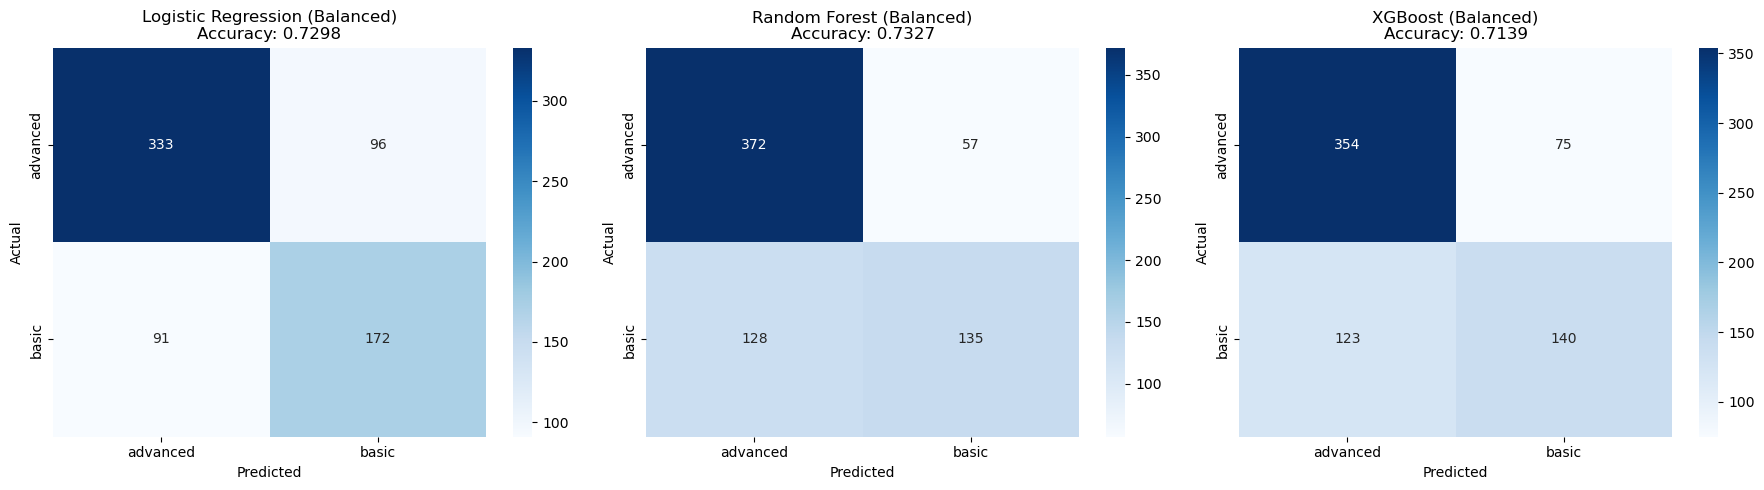

/var/folders/8t/d2wnktds38596jzn7mbqcn280000gn/T/ipykernel_10894/3205082117.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature Name', data=feature_df, palette='viridis')


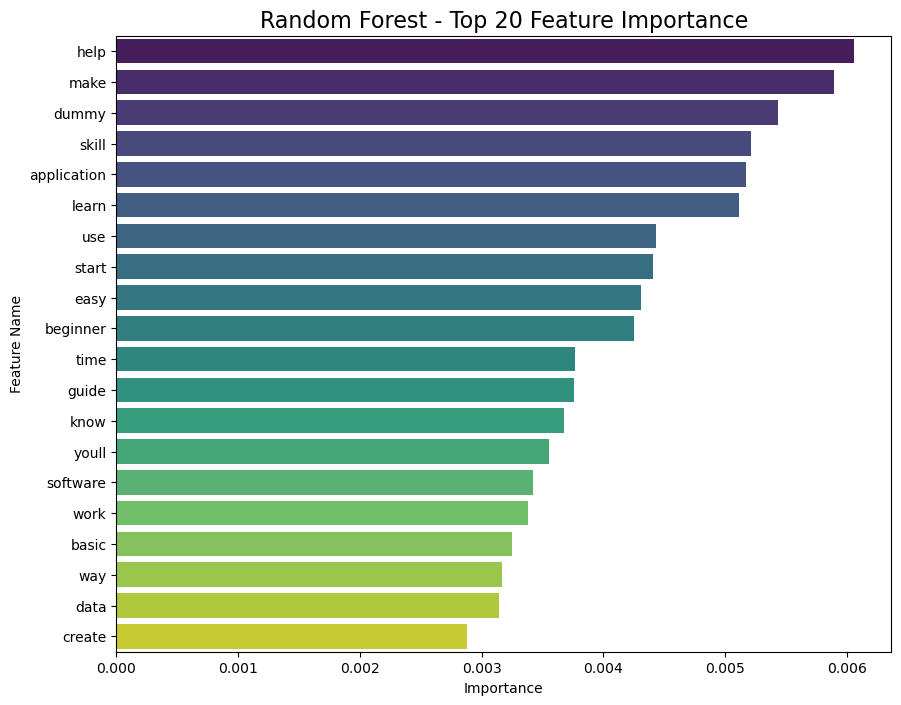

In [149]:
# Plot confusion matrices and feature importance for model evaluation
plot_confusion_matrices(y_test, results)
tfidf_names = list(tfidf_vect.get_feature_names_out())
plot_feature_importance_rf(results['Random Forest (Balanced)']['model'], tfidf_names, 20)

In [157]:
import collections
import numpy as np
import pandas as pd
import re
import random
import inspect
import os
from argparse import Namespace
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
import transformers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [158]:
args = Namespace(                              
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    seed=6312,
    MODEL_NAME = 'bert-base-uncased',
    NUM_LABELS = 2,
    LEARNING_RATE = 2e-5,
    BATCH_SIZE = 16,
    EPOCHS = 5,
    MAX_LEN = 512
)

In [159]:
df_dl = df_cl.copy()
df_dl.head()

,text,level,label
0,ai engineering recent breakthrough ai increase...,Intermediate to advanced,0
1,design data-intensive application author marti...,Intermediate to advanced,0
2,building application ai agent generative ai re...,Beginner to intermediate,1
3,hands-on machine learn scikit-learn pytorch po...,Intermediate to advanced,0
4,hands-on machine learn scikit-learn kera tenso...,Intermediate to advanced,0


In [160]:
by_label = collections.defaultdict(list)
for _, row in df_dl.iterrows():
    by_label[row.label].append(row.to_dict())

In [161]:
# split dateset to train, validate and test dataset and stored in list
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_label.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    n_test = int(args.test_proportion * n_total)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val' 
    for item in item_list[n_train+n_val:n_train+n_val+n_test]:
        item['split'] = 'test'
    

    # Add to final list
    final_list.extend(item_list) 

In [162]:
# switch split data list to dataframe
df_dl = pd.DataFrame(final_list)
df_dl.split.value_counts()

split
train    1613
val       345
test      345
Name: count, dtype: int64

In [175]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")

Using device: cpu


In [176]:
df_dl = df_dl[['text', 'label', 'split']]
df_dl.head()

,text,label,split
0,hhatgpt co der schule - modern unterrichten mi...,0,train
1,pro spring integration pro spring integration ...,0,train
2,master servicenow script explore depth service...,0,train
3,modern c learn c basic core feature advance co...,0,train
4,world class quality use design experiment make...,0,train


In [177]:
df_train = df_dl[df_dl['split'] == 'train']
df_val = df_dl[df_dl['split'] == 'val']
df_test = df_dl[df_dl['split'] == 'test']

In [178]:
train_status_counts = df_train['label'].value_counts()
print("Label Class Count：")
print(train_status_counts)

all_labels = sorted(df_train['label'].unique().tolist())

max_count = train_status_counts.max()
weights = [0.0] * len(all_labels)

for label in all_labels:
    count = train_status_counts.get(label, 0)
    
    weight = max_count / count if count > 0 else 0.0
    weights[label] = weight
    print(f"label: {label} | count: {count} | weight: {weight:.2f}")

class_weights_tensor = torch.tensor(weights, dtype=torch.float32)

args.CLASS_WEIGHTS = class_weights_tensor

Label Class Count：
label
0    1056
1     557
Name: count, dtype: int64
label: 0 | count: 1056 | weight: 1.00
label: 1 | count: 557 | weight: 1.90


In [179]:
X_train = df_train['text'].to_list()
y_train = df_train['label'].to_list()
X_val = df_val['text'].to_list()
y_val = df_val['label'].to_list()
X_test = df_test['text'].to_list()
y_test = df_test['label'].to_list()

In [180]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        # BERT Tokenization
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }    

In [181]:
tokenizer = BertTokenizer.from_pretrained(args.MODEL_NAME)

train_dataset = TextClassificationDataset(
    texts=X_train,      
    labels=y_train,    
    tokenizer=tokenizer, 
    max_len=args.MAX_LEN
)
train_data_loader = DataLoader(
    train_dataset, 
    batch_size=args.BATCH_SIZE, 
    shuffle=True
)

val_dataset = TextClassificationDataset(
    texts=X_val,
    labels=y_val,
    tokenizer=tokenizer, 
    max_len=args.MAX_LEN
)
val_data_loader = DataLoader(
    val_dataset, 
    batch_size=args.BATCH_SIZE
)

In [182]:
model = BertForSequenceClassification.from_pretrained(
    args.MODEL_NAME,
    num_labels=args.NUM_LABELS
)
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=args.LEARNING_RATE)

if hasattr(args, 'CLASS_WEIGHTS'):
    weighted_loss_fn = nn.CrossEntropyLoss(weight=args.CLASS_WEIGHTS.to(device))
    print('class_weights added')
else:
    weighted_loss_fn = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


class_weights added


In [183]:
def train_epoch(model, data_loader, optimizer, device, loss_fn):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(data_loader, desc='Training Batch')
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        progress_bar.set_postfix({'batch_loss': loss.item()})
    avg_loss = total_loss / len(data_loader)
    return avg_loss

In [184]:
def eval_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad(): 
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return accuracy_score(all_labels, all_preds)

In [ ]:
print("\n--- Start Training ---")
for epoch in range(args.EPOCHS):
    
    print(f"Epoch {epoch + 1}/{args.EPOCHS}")
    
    train_loss = train_epoch(model, train_data_loader, optimizer, device, weighted_loss_fn)
    
    val_accuracy = eval_model(model, val_data_loader, device)

    print(f"Epoch {epoch + 1} ending | train loss: {train_loss:.4f} | val accuracy: {val_accuracy:.4f}")


--- Start Training ---
Epoch 1/5


Training Batch:  81%|████████  | 82/101 [38:10<09:16, 29.28s/it, batch_loss=0.596]

In [ ]:
test_dataset = TextClassificationDataset(
    texts=X_test,
    labels=y_test,
    tokenizer=tokenizer, 
    max_len=args.MAX_LEN
)
test_data_loader = DataLoader(
    test_dataset, 
    batch_size=args.BATCH_SIZE
)

In [ ]:
def test_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return all_labels, all_preds


SKLearn classification report:
              precision    recall  f1-score   support

    Advanced     0.7500    0.9000    0.8182        20
       Basic     0.6000    0.3333    0.4286         9

    accuracy                         0.7241        29
   macro avg     0.6750    0.6167    0.6234        29
weighted avg     0.7034    0.7241    0.6973        29

Final Accuracy: 0.7241


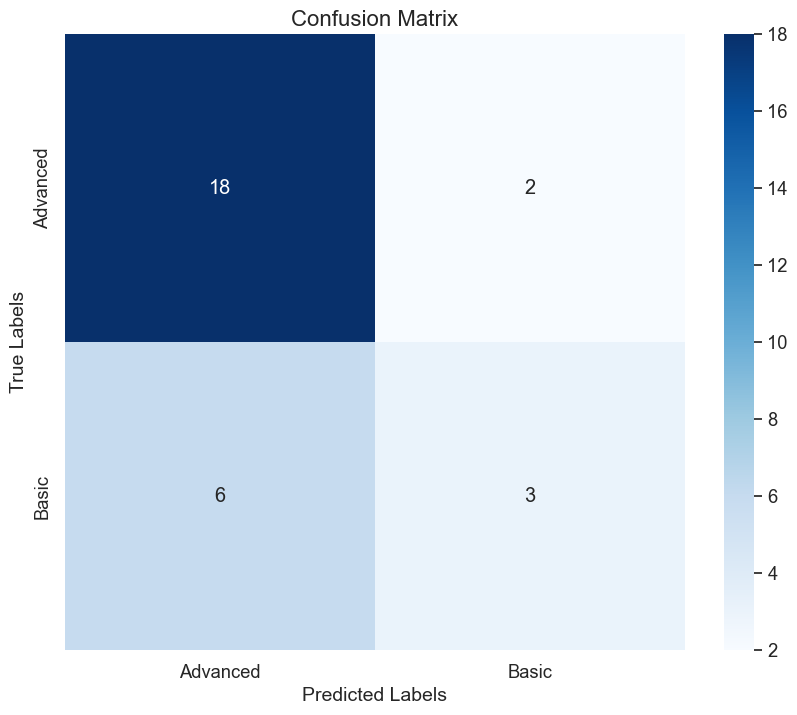

In [ ]:
CLASS_NAMES = ['Advanced', 'Basic']

true_labels, predictions = test_model(model, test_data_loader, device) 

print("\n" + "="*50)
print("SKLearn classification report:")
print("="*50)

final_accuracy = accuracy_score(true_labels, predictions)

report = classification_report(
    true_labels, 
    predictions, 
    target_names=CLASS_NAMES, 
    digits=4, 
    output_dict=False
)
print(report)
print("="*50)
print(f"Final Accuracy: {final_accuracy:.4f}")
print("==============================================")

cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)

sns.heatmap(
    cm, 
    annot=True,      
    fmt='d',       
    cmap='Blues',     
    xticklabels=CLASS_NAMES, 
    yticklabels=CLASS_NAMES 
)

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Labels', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=14)
plt.show()